In [1]:
import numpy as np
from numba import cuda
import math
import time

In [106]:
print("CUDA available:", cuda.is_available())
cuda.detect()


CUDA available: True
Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 2060'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-60dd62ca-003b-c0ee-92ca-c00b935ada13
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [ ]:


def InitMem(n, c):
    
    U = np.random.rand(n, c).astype(np.float64)
    Rsum = U.sum(axis=1)
    
    Rsum[Rsum == 0] = 1.0
    NU = U / Rsum[:, None]
    return NU


@cuda.jit
def return_mem(arr, m, mf):
    
    x, y = cuda.grid(2)
    sx, sy = cuda.gridsize(2)

    for i in range(x, arr.shape[0], sx):
        for j in range(y, arr.shape[1], sy):
            mf[i, j] = arr[i, j]**m

@cuda.jit
def transpose_2d_kernel(input_arr, output_arr):
   
    x, y = cuda.grid(2)

    if x < input_arr.shape[0] and y < input_arr.shape[1]:
        output_arr[y, x] = input_arr[x, y]

@cuda.jit
def update_centroid_kernel_2d(mf_T, data, Cen_out):
   
    i = cuda.grid(1)
    
    
    c = Cen_out.shape[0]
    n = data.shape[0]
    d = Cen_out.shape[1]
    
    if i < c:
        denominator = 0.0
        
        
        for j in range(n):
            mf_val = mf_T[i, j]
            
            denominator += mf_val
            
            
            for k in range(d):
                
                Cen_out[i, k] += mf_val * data[j, k]

       
        if denominator != 0.0:
            for k in range(d):
                Cen_out[i, k] = Cen_out[i, k] / denominator
        

@cuda.jit
def pairwise_distance(A, B, D):
   
    i, j = cuda.grid(2)
    
    
    if i < A.shape[0] and j < B.shape[0]:
        temp = 0.0
        for k in range(A.shape[1]):
            diff = A[i, k] - B[j, k]
            temp += diff * diff
        
        D[i, j] = temp 

@cuda.jit
def objective_kernel_strided(mf, dist_mat, result):
   
    n, c = mf.shape
    total_elements = n * c
    idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    temp_sum = 0.0

    while idx < total_elements:
        i = idx // c
        j = idx % c
        temp_sum += mf[i, j] * dist_mat[i, j]
        idx += stride

    
    cuda.atomic.add(result, 0, temp_sum)

@cuda.jit
def update_membership_strided(Dist, UpdatedMem, m):
   
    n, c = Dist.shape
    idx = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    
    exp = -2.0 / (m - 1.0)

    
    for i in range(idx, n, stride):
        sum_temp = 0.0
        
       
        for j in range(c):
            val = Dist[i, j]
            if val == 0.0:
                val = 1e-10  
            tmp = val ** exp
            sum_temp += tmp
        
        if sum_temp == 0.0:
            sum_temp = 1e-10

        
        for j in range(c):
            val = Dist[i, j]
            if val == 0.0:
                val = 1e-10
            tmp = val ** exp
            UpdatedMem[i, j] = tmp / sum_temp


def Objective_Fun_CUDA(mf_gpu, dist_gpu):
    
    result_gpu = cuda.to_device(np.zeros(1, dtype=np.float64))

   
    threads = 256
    blocks = (mf_gpu.size + threads - 1) // threads

    objective_kernel_strided[blocks, threads](mf_gpu, dist_gpu, result_gpu)
    
    objvalue = result_gpu.copy_to_host()[0]
    return objvalue


def FCM_gpu(Data, c, m, MaxItter):
    n, d = Data.shape  
    threads_2d = (16, 16)
    blocks_2d = ((n + threads_2d[0] - 1) // threads_2d[0],
                 (c + threads_2d[1] - 1) // threads_2d[1])

    
    threads_1d = 256
    
    
    blocks_1d_n = (n + threads_1d - 1) // threads_1d
    
    
    blocks_1d_c = (c + threads_1d - 1) // threads_1d

    
    Uinit = InitMem(n, c) 
    U_old_host = Uinit.copy() 
    U_current_host = np.empty_like(Uinit)

    
    data_gpu = cuda.to_device(np.ascontiguousarray(Data, dtype=np.float64))
    U_gpu = cuda.to_device(np.ascontiguousarray(Uinit, dtype=np.float64)) 
    UNew_gpu = cuda.device_array_like(U_gpu) 
    
    mf = cuda.device_array_like(U_gpu)
    mf_T = cuda.device_array(shape=(c, n), dtype=np.float64)
    
    Dist_Mat = cuda.device_array(shape=(n, c), dtype=np.float64)
    cen = cuda.device_array(shape=(c, d), dtype=np.float64) 
    
    OldDif = 0.0
    obj_val = []

    
    for i in range(MaxItter):
        
        
        return_mem[blocks_2d, threads_2d](U_gpu, m, mf)
        
        
        transpose_2d_kernel[blocks_2d, threads_2d](mf, mf_T)

        
        cen.copy_to_device(np.zeros((c, d), dtype=np.float64)) # Zero buffer
        update_centroid_kernel_2d[blocks_1d_c, threads_1d](mf_T, data_gpu, cen)
        
        
        pairwise_distance[blocks_2d, threads_2d](data_gpu, cen, Dist_Mat)
        
        
        obj = Objective_Fun_CUDA(mf, Dist_Mat)
        obj_val.append(obj)
        
       
        update_membership_strided[blocks_1d_n, threads_1d](Dist_Mat, UNew_gpu, m)
        
        
        UNew_gpu.copy_to_host(U_current_host)
        Dif = (np.absolute(U_current_host - U_old_host)).sum()
        
       
        print("Itteration ", i, "Differnce", Dif )

        if (Dif < 0.01):
            print("  Convergence reached.")
            break
            
        OldDif = Dif
        
        U_old_host = U_current_host.copy()
        U_gpu.copy_to_device(UNew_gpu) 

    
    Cen_return = cen.copy_to_host()
    U_return = U_gpu.copy_to_host() 
    
    return U_return, Cen_return, obj_val



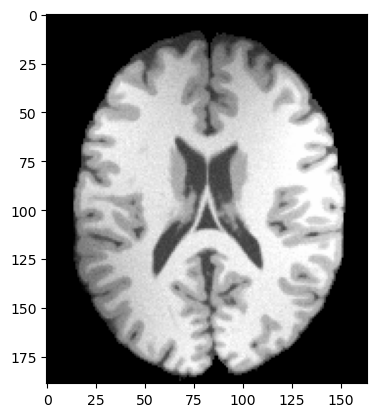

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img
# testimage=img.imread('photoshop_created_image5.png')
testimage=img.imread('brainweb90.tif')
# testimage2=img.imread('brain_mri.jpeg')
plt.imshow(testimage,cmap='gray')
plt.show()

In [4]:
import cv2
img_gray = cv2.cvtColor(testimage, cv2.COLOR_BGR2GRAY)

In [5]:
eps=0.00001
# upload image here from your drive
#image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/imgI.jpeg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#numpydata = asarray(image)
#data = numpydata.astype(float)
data_flatten = np.ravel(img_gray)
# data_flatten2 = np.ravel(testimage, axi)

p = data_flatten.shape[0]
data_flatten= np.reshape(data_flatten,(p,1))

In [71]:
U_gpu,Cen_gpu,obj_gpu = FCM_gpu(data_flatten,c=4,m=2,MaxItter=10000)

Starting GPU FCM: n=30996, d=1, c=4


c:\Users\Ayush\Desktop\sample1\env\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\Ayush\Desktop\sample1\env\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 122 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Itteration  0 Differnce 14213.791843350911
Itteration  1 Differnce 5463.982524268366
Itteration  2 Differnce 22117.88112134747
Itteration  3 Differnce 17700.82699837491
Itteration  4 Differnce 12292.729540384877
Itteration  5 Differnce 4512.132526461161
Itteration  6 Differnce 3118.5130986559916
Itteration  7 Differnce 2497.1791980216008
Itteration  8 Differnce 1874.0629352604244
Itteration  9 Differnce 1307.3372814155368
Itteration  10 Differnce 891.1699086000006
Itteration  11 Differnce 610.6317447803234
Itteration  12 Differnce 423.41250630589366
Itteration  13 Differnce 296.8141578097861
Itteration  14 Differnce 209.80281423848
Itteration  15 Differnce 149.18595683471665
Itteration  16 Differnce 106.52889364331386
Itteration  17 Differnce 76.29380341543228
Itteration  18 Differnce 54.75319060063934
Itteration  19 Differnce 39.35140123782514
Itteration  20 Differnce 28.31117301273599
Itteration  21 Differnce 20.383401432217678
Itteration  22 Differnce 14.683234332231985
Itteration  

In [72]:
Umax_gpu = (U_gpu == U_gpu.max(axis=1)[:,None]).astype(int)
print(Umax_gpu.shape)
seg1_gpu = Umax_gpu[:,0]
seg1_gpu = np.reshape(seg1_gpu,img_gray.shape)
seg2_gpu = Umax_gpu[:,1]
seg2_gpu = np.reshape(seg2_gpu,img_gray.shape)
seg3_gpu = Umax_gpu[:,2]
seg3_gpu = np.reshape(seg3_gpu,img_gray.shape)
seg4_gpu = Umax_gpu[:,3]
seg4_gpu = np.reshape(seg4_gpu,img_gray.shape)
# plt.imshow(img_gray,'gray')
# print(data.shape)

(30996, 4)


In [73]:
seg1_gpu,seg2_gpu,seg3_gpu,seg4_gpu=sorted([seg1_gpu,seg2_gpu,seg3_gpu,seg4_gpu],key=lambda m:np.mean(m))

[]

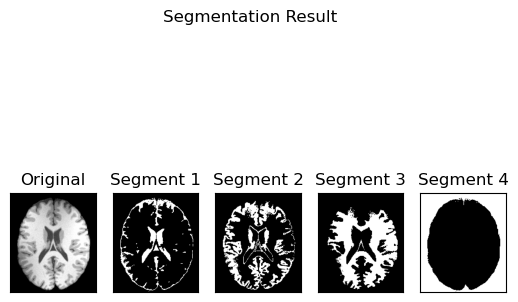

In [74]:
fig, axs = plt.subplots(1,5)
fig.suptitle('Segmentation Result')
axs[0].imshow(testimage,'gray')
axs[0].set_title('Original')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1_gpu,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2_gpu,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3_gpu,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4_gpu,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])




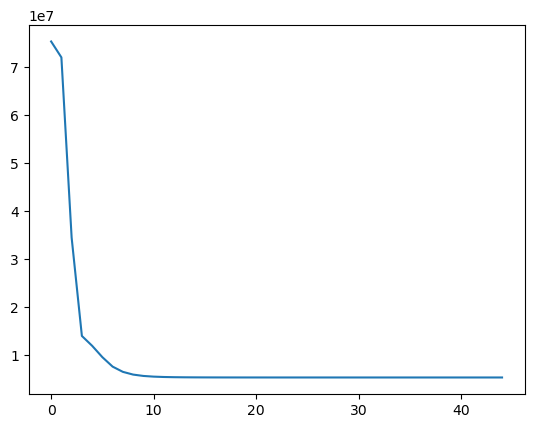

In [75]:
def Plot(obj):
  y = obj
  y.pop(0)
  x = list(range(0,len(obj)))
  return plt.plot(x, y)
Plot(obj_gpu)

In [65]:
def InitMem(n,c):
  U = np.random.rand(n,c)
  Rsum = U.sum(axis=1)
  NU = U/Rsum[:, None]
  return NU

def UpdateMem(data,Cen,m):
  Dist_Mat = Distance_Mat(data,Cen)
  Temp = Dist_Mat**(-2/(m-1))
  SumTemp = Temp.sum(axis=1)
  UpdatedMem = Temp/SumTemp[:,None]
  return UpdatedMem

def Distance_Mat(data,Cen):
  DS = data.shape
  CS = Cen.shape
  eps = 0.000001
  Dist = np.zeros((DS[0],CS[0]))
  for i in range(DS[0]):
    for j in range(CS[0]):
      sum = 0
      for k in range(DS[1]):
        sum = sum + (data[i,k] - Cen[j,k])**2
      Dist[i,j]=sum**0.5
  return Dist + eps

def Distance_MatNew(data,Cen):
  DS = data.shape
  CS = Cen.shape
  eps = 0.000001
  Dist = np.zeros((DS[0],CS[0]))
  for j in range(CS[0]):
    Temp = Cen[j,:];
    Cenj = np.repeat(Temp,DS[0],axis = 0)
    Dist[:,j] = ((data - Cenj)**2).sum(axis=1)
  return Dist + eps

def Objective_Fun(mf,Dist_Mat):
  obj = np.multiply(mf,Dist_Mat)
  objvalue = (obj.sum(axis = 0)).sum()
  return objvalue

def UpdateCen(mf,data):
  mf = (mf.transpose())**2
  mfSum = mf.sum(axis = 1)
  MulUD = np.dot(mf,data)
  Cen = MulUD/mfSum[:,None]
  return Cen

def FCM(Data,c,m,MaxItter):
  n, d = Data.shape
  Uinit = InitMem(n,c)
  U = Uinit
  OldDif = 0.0
  for i in range(MaxItter):
    mf = U**(m)
    Cen = UpdateCen(mf,Data)
    Dist_Mat = Distance_Mat(Data,Cen)
    obj = Objective_Fun(mf,Dist_Mat)
    UNew = UpdateMem(Data,Cen,m)
    Dif = ((np.absolute(U-UNew)).sum(axis=1)).sum()
    print("Itteration ", i, "Differnce", Dif )
    if (np.absolute(OldDif-Dif)<0.01):
      break
    OldDif = Dif
    U = UNew
  return U, Cen

In [66]:
U,Cen = FCM(data_flatten,c=4,m=2,MaxItter=100)

Itteration  0 Differnce 14221.054152404506
Itteration  1 Differnce 5834.003829786442
Itteration  2 Differnce 16406.99613050768
Itteration  3 Differnce 13321.781407701332
Itteration  4 Differnce 18274.4365629584
Itteration  5 Differnce 5595.101754399191
Itteration  6 Differnce 2232.4340163027346
Itteration  7 Differnce 1193.1322159953856
Itteration  8 Differnce 776.7752922947177
Itteration  9 Differnce 552.1023332076716
Itteration  10 Differnce 406.41423358849914
Itteration  11 Differnce 302.39330078565786
Itteration  12 Differnce 225.49493874891124
Itteration  13 Differnce 168.003004185309
Itteration  14 Differnce 124.97893663152571
Itteration  15 Differnce 92.86394105503709
Itteration  16 Differnce 68.94220782564855
Itteration  17 Differnce 51.15292118236376
Itteration  18 Differnce 37.94146631650287
Itteration  19 Differnce 28.138219380812888
Itteration  20 Differnce 20.869423912675913
Itteration  21 Differnce 15.478332868793544
Itteration  22 Differnce 11.480381501396312
Itteration 

In [67]:
Umax = (U == U.max(axis=1)[:,None]).astype(int)
print(Umax.shape)
seg1 = Umax[:,0]
seg1 = np.reshape(seg1,img_gray.shape)
seg2 = Umax[:,1]
seg2 = np.reshape(seg2,img_gray.shape)
seg3 = Umax[:,2]
seg3 = np.reshape(seg3,img_gray.shape)
seg4 = Umax[:,3]
seg4 = np.reshape(seg4,img_gray.shape)
# plt.imshow(img_gray,'gray')
# print(data.shape)

(30996, 4)


In [68]:
seg1,seg2,seg3,seg4=sorted([seg1,seg2,seg3,seg4],key=lambda m:np.mean(m))

[]

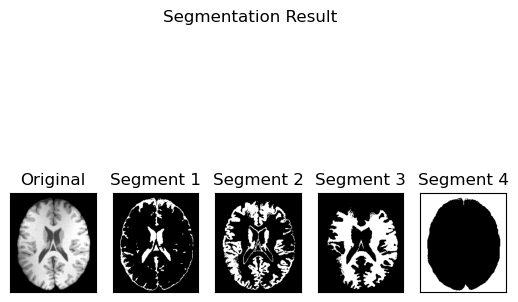

In [69]:
fig, axs = plt.subplots(1,5)
fig.suptitle('Segmentation Result')
axs[0].imshow(testimage,'gray')
axs[0].set_title('Original')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(seg1,'gray')
axs[1].set_title('Segment 1')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow(seg2,'gray')
axs[2].set_title('Segment 2')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(seg3,'gray')
axs[3].set_title('Segment 3')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(seg4,'gray')
axs[4].set_title('Segment 4')
axs[4].set_xticks([])
axs[4].set_yticks([])


In [76]:
print(np.abs(seg4-seg4_gpu))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [77]:
print(np.unique(np.abs(seg4-seg4_gpu)))

[0 1]


In [ ]:
unique_elements1, counts1 = np.unique(np.abs(seg1-seg1_gpu), return_counts=True)


element_counts1 = dict(zip(unique_elements1, counts1))

print(f"Original array: {np.abs(seg1-seg1_gpu)}")
print(f"Unique elements: {unique_elements1}")
print(f"Counts of each unique element: {counts1}")
print(f"Element counts dictionary: {element_counts1}")

Original array: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique elements: [0 1]
Counts of each unique element: [30806   190]
Element counts dictionary: {0: 30806, 1: 190}


In [79]:
print(f"accuracy in seg 1 = {np.abs((element_counts1[0])/(element_counts1[0]+element_counts1[1]))*100} %")

accuracy in seg 1 = 99.3870176797006 %


In [ ]:
unique_elements2, counts2 = np.unique(np.abs(seg2-seg2_gpu), return_counts=True)


element_counts2 = dict(zip(unique_elements2, counts2))

print(f"Original array: {np.abs(seg2-seg2_gpu)}")
print(f"Unique elements: {unique_elements2}")
print(f"Counts of each unique element: {counts2}")
print(f"Element counts dictionary: {element_counts2}")

Original array: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique elements: [0 1]
Counts of each unique element: [30540   456]
Element counts dictionary: {0: 30540, 1: 456}


In [81]:
print(f"accuracy in seg 2 = {np.abs((element_counts2[0])/(element_counts2[0]+element_counts2[1]))*100} %")

accuracy in seg 2 = 98.52884243128146 %


In [ ]:
unique_elements3, counts3 = np.unique(np.abs(seg3-seg3_gpu), return_counts=True)


element_counts3 = dict(zip(unique_elements3, counts3))

print(f"Original array: {np.abs(seg3-seg3_gpu)}")
print(f"Unique elements: {unique_elements3}")
print(f"Counts of each unique element: {counts3}")
print(f"Element counts dictionary: {element_counts3}")

Original array: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique elements: [0 1]
Counts of each unique element: [30690   306]
Element counts dictionary: {0: 30690, 1: 306}


In [83]:
print(f"accuracy in seg 3 = {np.abs((element_counts3[0])/(element_counts3[0]+element_counts3[1]))*100} %")

accuracy in seg 3 = 99.01277584204414 %


In [ ]:
unique_elements4, counts4 = np.unique(np.abs(seg4-seg4_gpu), return_counts=True)


element_counts4 = dict(zip(unique_elements4, counts4))

print(f"Original array: {np.abs(seg4-seg4_gpu)}")
print(f"Unique elements: {unique_elements4}")
print(f"Counts of each unique element: {counts4}")
print(f"Element counts dictionary: {element_counts4}")

Original array: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique elements: [0 1]
Counts of each unique element: [30956    40]
Element counts dictionary: {0: 30956, 1: 40}


In [85]:
print(f"accuracy in seg 4 = {np.abs((element_counts4[0])/(element_counts4[0]+element_counts4[1]))*100} %")

accuracy in seg 4 = 99.8709510904633 %


In [90]:
time_by_cpu = %timeit -o FCM(data_flatten,c=4,m=2,MaxItter=100)

Itteration  0 Differnce 14299.780147774258
Itteration  1 Differnce 5528.0182102240215
Itteration  2 Differnce 11433.057482131631
Itteration  3 Differnce 13490.714937793155
Itteration  4 Differnce 15581.621785840936
Itteration  5 Differnce 8587.078758822972
Itteration  6 Differnce 3665.2935899547647
Itteration  7 Differnce 2334.141398158745
Itteration  8 Differnce 1643.5070080423814
Itteration  9 Differnce 1276.55810441415
Itteration  10 Differnce 1036.4870269189748
Itteration  11 Differnce 837.0282537892979
Itteration  12 Differnce 661.7460579979465
Itteration  13 Differnce 512.4253673728213
Itteration  14 Differnce 390.66966299871416
Itteration  15 Differnce 294.6544712196768
Itteration  16 Differnce 220.80166293991755
Itteration  17 Differnce 164.72732709893842
Itteration  18 Differnce 122.53570521162914
Itteration  19 Differnce 91.00801966486003
Itteration  20 Differnce 67.52913998298749
Itteration  21 Differnce 50.08093186269846
Itteration  22 Differnce 37.1325280598813
Itteration 

In [92]:
time_by_gpu = %timeit -o FCM_gpu(data_flatten,c=4,m=2,MaxItter=10000)

Itteration  0 Differnce 14209.104083556691
Itteration  1 Differnce 6436.745295637218
Itteration  2 Differnce 21992.16891331993
Itteration  3 Differnce 16314.251530211706
Itteration  4 Differnce 12176.707810990581
Itteration  5 Differnce 3140.854281300152
Itteration  6 Differnce 3351.8321991362986
Itteration  7 Differnce 2992.664752807524
Itteration  8 Differnce 2413.289318747812
Itteration  9 Differnce 1773.9430284236812
Itteration  10 Differnce 1223.2938393921759
Itteration  11 Differnce 831.9417928309547
Itteration  12 Differnce 570.657193869491
Itteration  13 Differnce 396.36887695295235
Itteration  14 Differnce 278.27777485170293
Itteration  15 Differnce 196.92729579789682
Itteration  16 Differnce 140.1484430694924
Itteration  17 Differnce 100.1353479368169
Itteration  18 Differnce 71.74584550057827
Itteration  19 Differnce 51.504859158269475
Itteration  20 Differnce 37.02477909302257
Itteration  21 Differnce 26.6413699153338
Itteration  22 Differnce 19.183323463410108
Itteration  

In [93]:
print(time_by_cpu.best- time_by_gpu.best)

9.92327720002504


In [95]:
Speedup_Factor = time_by_cpu.best / time_by_gpu.best
Percentage_Speedup = (Speedup_Factor - 1) * 100

In [96]:
print(Percentage_Speedup)

2929.5234160281375


In [97]:
print(Speedup_Factor)

30.295234160281375


In [98]:
categories = ['cpu', 'gpu']
data = [time_by_cpu.best, time_by_gpu.best]

Text(0, 0.5, 'Time Taken')

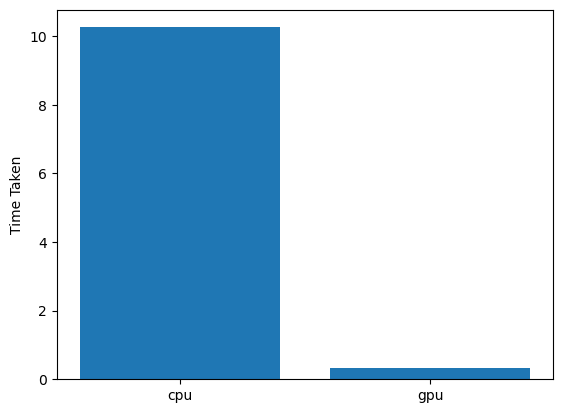

In [99]:
plt.bar(categories, data)
# plt.xlabel('Times')
plt.ylabel('Time Taken')
# plt.title('My Bar Plot')

In [100]:
#throughput
xd,yd = img_gray.shape
total_points = xd*yd
print(total_points)

30996


In [101]:
throughput_cpu = total_points/time_by_cpu.best
print(throughput_cpu)

3020.460697820778


In [102]:
throughput_gpu = total_points/time_by_gpu.best
print(throughput_gpu)

91505.56411240736


In [103]:
throughput_data = [throughput_cpu, throughput_gpu]

Text(0, 0.5, 'Throughput')

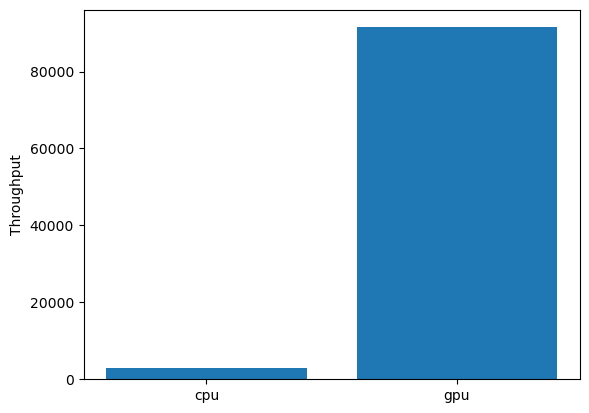

In [104]:
plt.bar(categories, throughput_data)
# plt.xlabel('Times')
plt.ylabel('Throughput')
# plt.title('My Bar Plot')

In [105]:
throughput_incease_factor = throughput_gpu/throughput_cpu
print(throughput_incease_factor)

30.295234160281378
